In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# from numpy.random import seed
# seed(1)

# from tensorflow import set_random_seed
# set_random_seed(1)

tf.random.set_seed(1)

2023-06-03 13:29:26.635060: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-03 13:29:27.109899: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
df = pd.read_csv("/home/ceg98/Documents/archive/artists.csv")
df.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


In [4]:
artists = df.sort_values(by=['paintings'], ascending=False)
artists.head(10)

,id,name,years,genre,nationality,bio,wikipedia,paintings
8,8,Vincent van Gogh,1853 – 1890,Post-Impressionism,Dutch,Vincent Willem van Gogh (Dutch: [ˈvɪnsɛnt ˈʋɪl...,http://en.wikipedia.org/wiki/Vincent_van_Gogh,877
30,30,Edgar Degas,1834 - 1917,Impressionism,French,Edgar Degas (US: or UK: ; born Hilaire-Germai...,http://en.wikipedia.org/wiki/Edgar_Degas,702
13,13,Pablo Picasso,1881 - 1973,Cubism,Spanish,Pablo Ruiz Picasso (; Spanish: [ˈpaβlo piˈkaso...,http://en.wikipedia.org/wiki/Pablo_Picasso,439
15,15,Pierre-Auguste Renoir,1841 - 1919,Impressionism,French,"Pierre-Auguste Renoir, commonly known as Augus...",http://en.wikipedia.org/wiki/Pierre-Auguste_Re...,336
19,19,Albrecht Dürer,1471 - 1528,Northern Renaissance,German,Albrecht Dürer (; German: [ˈʔalbʁɛçt ˈdyːʁɐ]; ...,http://en.wikipedia.org/wiki/Albrecht_Dürer,328
46,46,Paul Gauguin,1848 – 1903,"Symbolism,Post-Impressionism",French,"Eugène Henri Paul Gauguin (UK: , US: ; French:...",http://en.wikipedia.org/wiki/Paul_Gauguin,311
16,16,Francisco Goya,1746 - 1828,Romanticism,Spanish,Francisco José de Goya y Lucientes (; Spanish:...,http://en.wikipedia.org/wiki/Francisco_Goya,291
31,31,Rembrandt,1606 - 1669,Baroque,Dutch,Rembrandt Harmenszoon van Rijn (; Dutch: [ˈrɛm...,http://en.wikipedia.org/wiki/Rembrandt,262
20,20,Alfred Sisley,1839 - 1899,Impressionism,"French,British",Alfred Sisley (; French: [sislɛ]; 30 October 1...,http://en.wikipedia.org/wiki/Alfred_Sisley,259
32,32,Titian,1488 - 1576,"High Renaissance,Mannerism",Italian,Tiziano Vecelli or Tiziano Vecellio (pronounce...,http://en.wikipedia.org/wiki/Titian,255


In [5]:
artists.paintings.sum()

8446

In [6]:
# Sort artists by number of paintings
artists = df.sort_values(by=['paintings'], ascending=False)
weighted_artists = artists[['name', 'paintings']]
weighted_artists['weights'] = weighted_artists.paintings.sum() / (weighted_artists.shape[0] * weighted_artists.paintings)

weighted_artists.head()

# Create a dataframe with artists having more than 200 paintings
artists_top = df[df['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]
artists_top['class_weight'] = max(artists_top.paintings)/artists_top.paintings
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
artists_top['weights'] = artists_top['class_weight']
weighted_artists = artists_top

/tmp/ipykernel_34796/1288033912.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weighted_artists['weights'] = weighted_artists.paintings.sum() / (weighted_artists.shape[0] * weighted_artists.paintings)


In [7]:
# Set class weights - assign higher weights to underrepresented classes
class_weights = weighted_artists['weights'].to_dict()
class_weights

{0: 0.44563076604125634,
 1: 0.8902464278318493,
 2: 1.1631493506493507,
 3: 1.3430178069353327,
 4: 1.1915188470066518,
 5: 1.5089505089505089,
 6: 1.6352225180677062,
 7: 0.5567210567210568,
 8: 1.491672449687717,
 9: 1.532620320855615,
 10: 1.2566501023092662}

In [8]:
# Explore images of top artists
images_dir = "/home/ceg98/Documents/archive/resized/resized"
artists_dirs = os.listdir(images_dir)
artists_name = weighted_artists['name'].str.replace(' ', '_').values

['Vincent_van_Gogh' 'Pablo_Picasso' 'Pierre-Auguste_Renoir'
 'Francisco_Goya' 'Albrecht_Dürer' 'Alfred_Sisley' 'Marc_Chagall'
 'Edgar_Degas' 'Rembrandt' 'Titian' 'Paul_Gauguin']


# Don't Run 


In [10]:
# artists_name[4] = "Albrecht" 
# cur_index = 0
# dataset = []

# # Code from Charlie
# for pic_name in artists_dirs:
#     for artist in artists_name:
#         if artist in pic_name:
#             observation = dict()
#             observation["label"] = artist
#             observation["pic-name"] = pic_name
#             dataset.append(observation)
            

In [11]:
# # Renaming Albrecht files becuase Windows has trouble reading all his weird characters. 

# import os
# import re

# # Iterate over the files
# for file_name in artists_dirs:
#     if "Albrecht" in file_name:
#         # Extract the existing number from the file name
#         match = re.search(r"_([0-9]+)\.jpg", file_name)
#         if match:
#             existing_number = match.group(1)
#         else:
#             existing_number = ""

#         # Create the new file name
#         new_file_name = f"Albrecht_{existing_number}.jpg"

#         # Get the current file path
#         current_file_path = images_dir + '/' + file_name

#         # Generate the new file path
#         new_file_path = images_dir + '/' + new_file_name

#         # Rename the file
#         os.rename(current_file_path, new_file_path)
        
#         print(f"Renamed '{file_name}' to '{new_file_name}'.")

# RUN ! lkjhasdjhnklsadlkjhhsadfglkjh;sdfgaglkhj;dfasklj dsfalkj fdsalkjdfa

In [12]:
import os
import shutil

# Specify the directory path containing the image files
images_dir = "/home/ceg98/Documents/archive/resized/resized"

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))]


for artist in artists_name:
    artist_folder = os.path.join(images_dir, artist)

    if not os.path.exists(artist_folder):
        os.makedirs(artist_folder)
    
    for image_file in image_files: 
        source_path = os.path.join(images_dir, image_file)
        if artist in source_path:
            destination_path = os.path.join(artist_folder, image_file)
            shutil.move(source_path, destination_path)

In [13]:
# See if all directories exist
for name in artists_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

Found --> /home/ceg98/Documents/archive/resized/resized/Vincent_van_Gogh
Found --> /home/ceg98/Documents/archive/resized/resized/Pablo_Picasso
Found --> /home/ceg98/Documents/archive/resized/resized/Pierre-Auguste_Renoir
Found --> /home/ceg98/Documents/archive/resized/resized/Francisco_Goya
Found --> /home/ceg98/Documents/archive/resized/resized/Albrecht_Dürer
Found --> /home/ceg98/Documents/archive/resized/resized/Alfred_Sisley
Found --> /home/ceg98/Documents/archive/resized/resized/Marc_Chagall
Found --> /home/ceg98/Documents/archive/resized/resized/Edgar_Degas
Found --> /home/ceg98/Documents/archive/resized/resized/Rembrandt
Found --> /home/ceg98/Documents/archive/resized/resized/Titian
Found --> /home/ceg98/Documents/archive/resized/resized/Paul_Gauguin


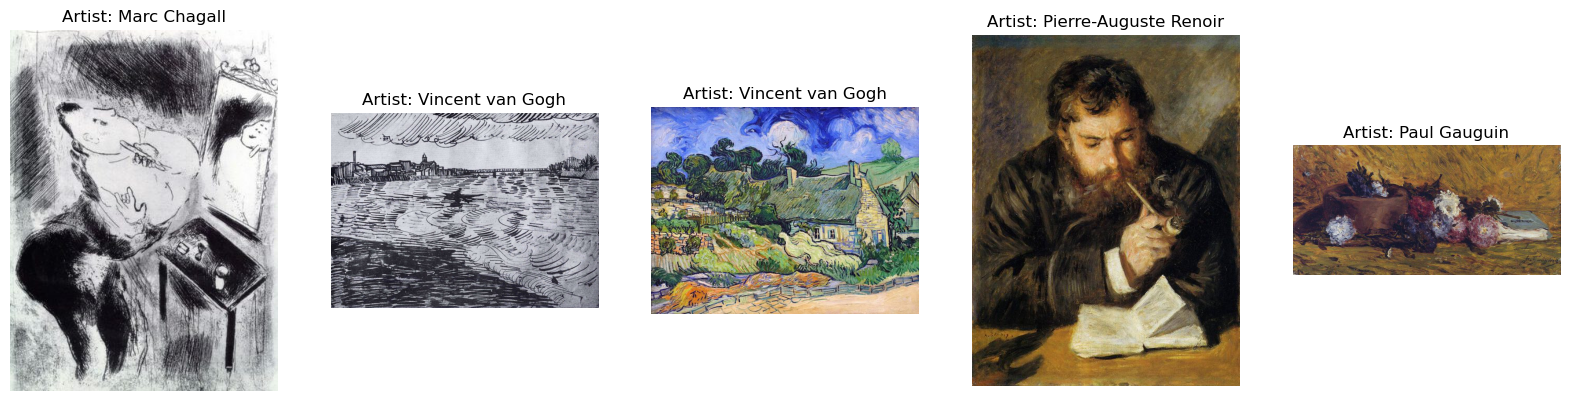

In [14]:
# Print few random paintings
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(artists_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()

In [15]:
# Augment data
batch_size = 32
train_input_shape = (225, 225, 3)
n_classes = weighted_artists.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   rotation_range=45,
                                #    width_shift_range=0.1,
                                #    height_shift_range=0.1,
                                 #   shear_range=5,
                                   zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_name.tolist()
                                                   )


valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_name.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 3181 images belonging to 11 classes.
Found 790 images belonging to 11 classes.
Total number of batches = 99 and 24


## Print a random paintings and it's random augmented version¶


IndexError: list index out of range

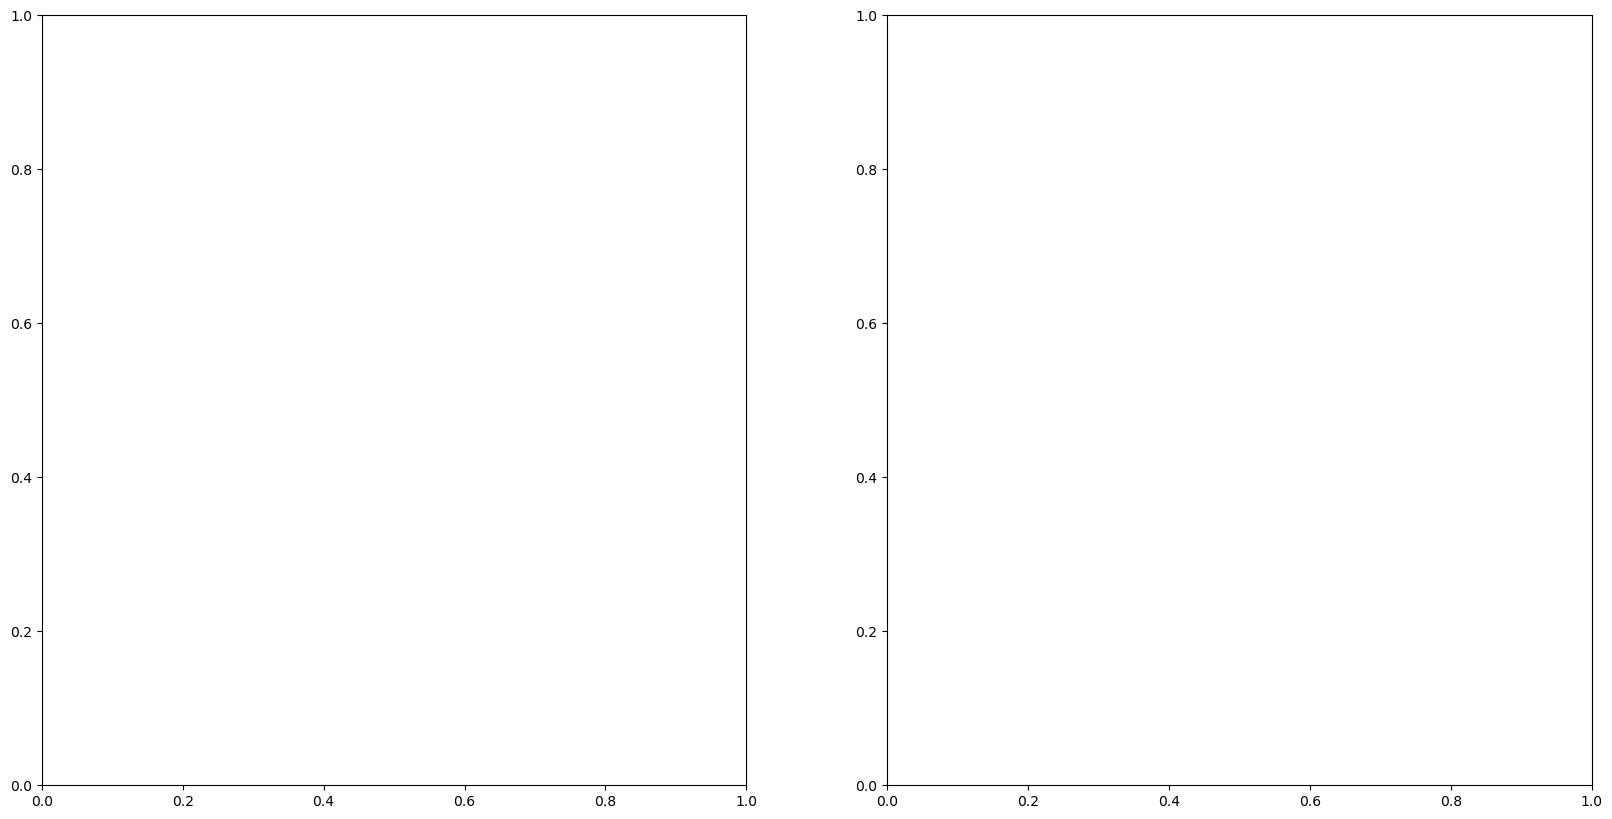

In [17]:
# Print a random paintings and it's random augmented version
fig, axes = plt.subplots(1, 2, figsize=(20,10))

random_artist = random.choice(artists_name)
random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
random_image_file = os.path.join(images_dir, random_artist, random_image)

# Original image
image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("An original Image of " + random_artist.replace('_', ' '))
axes[0].axis('off')

# Transformed image
aug_image = train_datagen.random_transform(image)
axes[1].imshow(aug_image)
axes[1].set_title("A transformed Image of " + random_artist.replace('_', ' '))
axes[1].axis('off')

plt.show()

## From here below may need adjusting hyperparameters

In [ ]:
# Load pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

# Add layers at the end
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

2023-06-03 11:55:15.896922: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-03 11:55:15.913846: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-03 11:55:15.913969: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [ ]:
optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [ ]:
n_epoch = 10

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [ ]:
import tensorflow as tf
# Train the model - all layers
class_weights = weighted_artists['weights'].to_dict()

history1 = model.fit_generator(generator=train_generator, 
                               steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, 
                              validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )


/tmp/ipykernel_30134/1535370668.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = model.fit_generator(generator=train_generator,


Epoch 1/10


2023-06-03 11:55:18.001881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [11]
	 [[{{node Placeholder/_3}}]]
2023-06-03 11:55:30.634553: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-03 11:55:31.830223: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-03 11:55:31.833665: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x20d47430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-03 11:55:31.833678: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2023-06-03 

99/99 [==============================] - ETA: 0s - loss: 1.8693 - accuracy: 0.3099

2023-06-03 11:56:07.870723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


99/99 [==============================] - 64s 351ms/step - loss: 1.8693 - accuracy: 0.3099 - val_loss: 2.7923 - val_accuracy: 0.0664 - lr: 0.0010
Epoch 2/10
99/99 [==============================] - 43s 393ms/step - loss: 1.5953 - accuracy: 0.4243 - val_loss: 3.0987 - val_accuracy: 0.0651 - lr: 0.0010
Epoch 3/10
99/99 [==============================] - 44s 400ms/step - loss: 1.4651 - accuracy: 0.4827 - val_loss: 3.4478 - val_accuracy: 0.0664 - lr: 0.0010
Epoch 4/10
99/99 [==============================] - 43s 399ms/step - loss: 1.3680 - accuracy: 0.5062 - val_loss: 10.0466 - val_accuracy: 0.0638 - lr: 0.0010
Epoch 5/10
99/99 [==============================] - 43s 392ms/step - loss: 1.3002 - accuracy: 0.5338 - val_loss: 3.7226 - val_accuracy: 0.0664 - lr: 0.0010
Epoch 6/10
99/99 [==============================] - ETA: 0s - loss: 1.2164 - accuracy: 0.5503
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
99/99 [==============================] - 43s 399ms/step - l

In [ ]:
# Freeze core ResNet layers and train again 
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[:50]:
    layer.trainable = True

optimizer = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

n_epoch = 50
if history1.history['accuracy'][-1] > .4:
    history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                                epochs=n_epoch,
                                shuffle=True,
                                verbose=1,
                                callbacks=[reduce_lr, early_stop],
                                use_multiprocessing=True,
                                workers=16,
                                class_weight=class_weights
                                )

/tmp/ipykernel_30134/3492011844.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,


Epoch 1/50


2023-06-03 12:03:33.979483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [11]
	 [[{{node Placeholder/_3}}]]


99/99 [==============================] - ETA: 0s - loss: 0.9613 - accuracy: 0.6453

2023-06-03 12:04:06.795149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


99/99 [==============================] - 47s 367ms/step - loss: 0.9613 - accuracy: 0.6453 - val_loss: 1.4966 - val_accuracy: 0.5065 - lr: 0.0010
Epoch 2/50
99/99 [==============================] - 44s 402ms/step - loss: 0.9130 - accuracy: 0.6742 - val_loss: 1.4977 - val_accuracy: 0.5013 - lr: 0.0010
Epoch 3/50
99/99 [==============================] - 44s 396ms/step - loss: 0.8861 - accuracy: 0.6777 - val_loss: 1.5062 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/50
99/99 [==============================] - 45s 406ms/step - loss: 0.8783 - accuracy: 0.6796 - val_loss: 2.1321 - val_accuracy: 0.3438 - lr: 0.0010
Epoch 5/50
99/99 [==============================] - 43s 395ms/step - loss: 0.8723 - accuracy: 0.6840 - val_loss: 2.3369 - val_accuracy: 0.3047 - lr: 0.0010
Epoch 6/50
99/99 [==============================] - ETA: 0s - loss: 0.8827 - accuracy: 0.6828

KeyboardInterrupt: 

## Training Graph

In [ ]:
# Merge history1 and history2
history = {}
history['loss'] = history1.history['loss'] + history2.history['loss']
history['accuracy'] = history1.history['accuracy'] + history2.history['accuracy']
history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss']
history['val_accuracy'] = history1.history['val_accuracy'] + history2.history['val_accuracy']
history['lr'] = history1.history['lr'] + history2.history['lr']

In [ ]:
# Plot the training graph
def plot_training(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    
plot_training(history)

NameError: name 'history' is not defined